In [80]:
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16, EfficientNetB0, ResNet101, DenseNet121
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
import os
from scipy import io
from sklearn.model_selection import train_test_split

def dice_coef(y_true, y_pred):
    return (2. * tf.math.reduce_sum(y_true * y_pred) + 1.) / (tf.math.reduce_sum(y_true) + tf.math.reduce_sum(y_pred) + 1.)

In [81]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10978896781515834816
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6235881472
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10497311318188845294
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [82]:
def display(display_list):
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    
    plt.figure(figsize=(15.15))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
    
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(model, dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        dispaly([sample_image, sample_mask,
                create_mask(model.predict(sample_image[tf.newaxis, ...]))])

## Загрузка датасета

In [83]:
DATASET_PATH = 'content/clothing-co-parsing/photos/'
MASK_PATH = 'content/clothing-co-parsing/annotations/pixel-level/'

In [84]:
def preprocess_image(image):
    image = tf.cast(image, tf.float32)
    image = image/255.0
    image = tf.image.resize(image, (128,128))
    return image

def preprocess_mask(mask):
    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.image.resize(mask, (128,128))
    mask = tf.cast(mask != 0, tf.uint8)
    return mask

In [85]:
images = []
masks = []

for mask_filename in os.listdir(MASK_PATH):
    image_filename = mask_filename[:-4] + '.jpg'
    image = img_to_array(load_img(DATASET_PATH + image_filename))
    images.append(preprocess_image(image))
    
    mask_file = io.loadmat(MASK_PATH + mask_filename)
    mask = tf.convert_to_tensor(mask_file['groundtruth'])
    masks.append(preprocess_mask(mask))

In [86]:
train_X, test_X, train_Y, test_Y = train_test_split(images, masks, \
                                                   test_size=0.2, random_state=0)
sample_image, sample_mask = train_X[0], train_Y[0]

train_X = tf.data.Dataset.from_tensor_slices(train_X)
test_X = tf.data.Dataset.from_tensor_slices(test_X)
train_Y = tf.data.Dataset.from_tensor_slices(train_Y)
test_Y = tf.data.Dataset.from_tensor_slices(test_Y)

train = tf.data.Dataset.zip((train_X, train_Y))
test = tf.data.Dataset.zip((test_X, test_Y))

In [87]:
# Функции для аугментации

# яркость
def brightness(img, mask):
    img = tf.image.adjust_hue(img, -0.1)
    return img, mask

# оттенок
def hue(img, mask):
    img = tf.image.adjust_hue(img, -0.1)
    return img, mask

# отзеркаливание по горизонтали
def flip_horisontal(img, mask):
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    return img, mask

In [88]:
train = train.concatenate(train.map(brightness))
train = train.concatenate(train.map(hue))
train = train.concatenate(train.map(flip_horisontal))

In [89]:
len(train)

6424

In [90]:
BATCH_SIZE = 32
BUFFER_SIZE = 500
train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train = train.prefetch(buffer_size=BUFFER_SIZE)
test = test.batch(BATCH_SIZE)

In [99]:
def bloc_transpose(x,block_out, numb_filter = [128,128]):
    x = concatenate([x, block_out])
    x = Conv2D(numb_filter[0], (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(numb_filter[0], (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # UP
    x = Conv2DTranspose(numb_filter[1], (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

In [103]:
pre_trained_model = VGG16(input_shape=(128, 128, 3), include_top=False, weights="imagenet")

def unet_pre_train(num_classes = 1, input_shape= (128, 128, 3), pre_trained_model = None, pretrain_out = 1,list_bloc = [10,6,3]):
    if pre_trained_model != None:
        for layer in pre_trained_model.layers[:len(pre_trained_model.layers)]:
            layer.trainable = False
        x = pre_trained_model.layers[pretrain_out].output # конец сверток
        block_out = [pre_trained_model.layers[i].output for i in list_bloc]
     
        img_input = pre_trained_model.inputs
        print(block_out[0])
        # первое уменьшение размера
    else:
        return None  
    # UP 1


    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

In [104]:
modelU = unet_pre_train(num_classes = 1, input_shape= (128, 128, 3), pre_trained_model = pre_trained_model)

KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 256), dtype=tf.float32, name=None), name='block3_pool/MaxPool:0', description="created by layer 'block3_pool'")
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 conv2d_25 (Conv2D)          (None, 128, 128, 64)      36928     
                                                                 
 batch_normalization_57 (Bat  (None, 128, 128, 64)     256       
 chNormalization)                                                
                                                                 
 activation_57 (Activation)  (None, 128, 128, 64)      0         
                         

In [108]:
history = modelU.fit(train, epochs = 30, batch_size = 3, validation_data = test)

Epoch 1/30
201/201 [==============================] - 5s 26ms/step - loss: 0.0000e+00 - dice_coef: 0.3794 - val_loss: 0.0000e+00 - val_dice_coef: 0.3789
Epoch 2/30
201/201 [==============================] - 5s 25ms/step - loss: 0.0000e+00 - dice_coef: 0.3794 - val_loss: 0.0000e+00 - val_dice_coef: 0.3789
Epoch 3/30
201/201 [==============================] - 5s 26ms/step - loss: 0.0000e+00 - dice_coef: 0.3794 - val_loss: 0.0000e+00 - val_dice_coef: 0.3789
Epoch 4/30
201/201 [==============================] - 5s 25ms/step - loss: 0.0000e+00 - dice_coef: 0.3794 - val_loss: 0.0000e+00 - val_dice_coef: 0.3789
Epoch 5/30
201/201 [==============================] - 5s 26ms/step - loss: 0.0000e+00 - dice_coef: 0.3794 - val_loss: 0.0000e+00 - val_dice_coef: 0.3789
Epoch 6/30
201/201 [==============================] - 5s 26ms/step - loss: 0.0000e+00 - dice_coef: 0.3794 - val_loss: 0.0000e+00 - val_dice_coef: 0.3789
Epoch 7/30
201/201 [==============================] - 5s 26ms/step - loss: 0.0000e

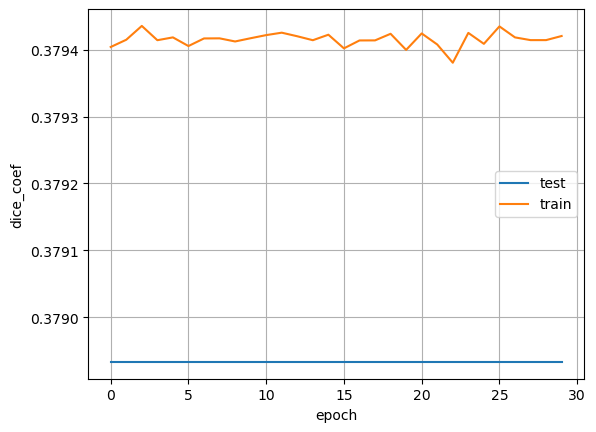

In [109]:
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.grid()
plt.show()

In [110]:
predu = modelU.predict(test)
print(predu.shape)

7/7 [==============================] - 0s 10ms/step
(201, 128, 128, 1)
